In [9]:
# from numpy.random import default_rng
# rng = default_rng(10)
# vals = rng.standard_normal(10)

In [ ]:
# synthetic data - Quadrant idea

In [6]:
number_of_conversation = 100

In [7]:
import numpy as np

def conversations(number_of_conversation):
    return np.random.randint(2,100,number_of_conversation)

In [8]:
def rand_low():
    return np.random.uniform(0,0.25)    

In [9]:
def rand_high():
    return np.random.uniform(0.75,1)    

In [10]:
def inc_sub_quad(quad, number_of_conversation):
    inc_list=[]
    sub_list=[]
    size_list = conversations(number_of_conversation)
    for i in range(0,number_of_conversation):
        if (quad == 1):
            inc = rand_low()
            sub = rand_low()

        if (quad == 2):
            inc = rand_low()
            sub = rand_high()

        if (quad == 3):
            inc = rand_high()
            sub = rand_high()

        if (quad == 4):
            inc = rand_high()
            sub = rand_low()
            
        inc_list.append(inc)
        sub_list.append(sub)
    return size_list, inc_list, sub_list

In [11]:
size_list, inc_list, sub_list = inc_sub_quad(2,number_of_conversation)

In [3]:
import networkx as nx
tree = nx.random_tree(n=10, seed=0, create_using=nx.DiGraph)

print(nx.forest_str(tree, sources=[0]))

╙── 0
    ├─╼ 3
    └─╼ 4
        ├─╼ 6
        │   ├─╼ 1
        │   ├─╼ 2
        │   └─╼ 7
        │       └─╼ 8
        │           └─╼ 5
        └─╼ 9


In [14]:
def create_tree(size_list):
    tree_list = []
    for size in size_list:
        tree = nx.random_tree(n=size, seed=0, create_using=nx.DiGraph)
        tree_list.append(tree)
    return tree_list

In [15]:
tree_list = create_tree(size_list)

In [38]:
def assign_labels(size_list, inc_list, sub_list, tree_list):
    for n,tree in enumerate(tree_list):
        node_dict={}
        # nodes = nodes(tree)
        size = size_list[n]
        inc = inc_list[n]
        sub = sub_list[n]
        nodes_inc = int(np.round(inc*size))
        nodes_sub = int(np.round(sub*size))
        seq_inc = np.random.randint(0,size,nodes_inc)
        seq_sub = np.random.randint(0,size,nodes_sub)
        for s in range(0,size):
            if s in seq_inc:
                inc_stat = "incivil"
            else:
                inc_stat = "civil"
            if s in seq_sub:
                sub_stat = "substantive"
            else:
                sub_stat = "non_substantive"
            node_dict[s] = {"inc":inc_stat, "sub":sub_stat}
        nx.set_node_attributes(tree, node_dict)
    
            

In [39]:
assign_labels(size_list,inc_list,sub_list,tree_list)

In [42]:
color = nx.get_node_attributes(tree_list[0], "sub")

In [5]:
### Non aggressive method of deletion :  Real Data

In [11]:
import pickle
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
import pandas as pd
from scipy import stats
import copy
import random
from random import sample
from scipy import stats

In [97]:
data_new = pickle.load(open("conv_temporal_det.pk", "rb"))

In [98]:
all_convo_inc=[]
all_convo_sub=[]
c=0
for data in data_new:
    all_convo_inc.extend(data_new[data]["incivility_temporal"])
    all_convo_sub.extend(data_new[data]["annotation_temporal"])
    
for i,n in enumerate(all_convo_inc):
    if (n==1.0):
        # if(all_convo_sub[i]=="L3" or all_convo_sub[i]=="L3"):
            c+=1
            
print(c/len(all_convo_inc))

0.19916832712466429


In [99]:
len(all_convo_inc)

11543

In [108]:
def index(l):
    idx = [i for i,val in enumerate(l) if val==1.0]
    return idx

def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)
    return list_object

In [119]:
def inc_removal(data_new):

    rep_removal_inc={}
    rep_removal_sub={}
    sub_frac=[]
    inc_frac=[]
    for data in data_new:
        idx = index(data_new[data]["incivility_temporal"])
        # print(data_new[data]["incivility_temporal"])
        # print(idx)
        # sys.exit(0)
        for i in range(0,len(idx)+1):
            inc = copy.deepcopy(data_new[data]["incivility_temporal"])
            sub = copy.deepcopy(data_new[data]["annotation_temporal"])
            idx_to_delete = sample(idx,i)
            if i != 0:
                inc = delete_multiple_element(inc,idx_to_delete)
                sub = delete_multiple_element(sub,idx_to_delete)
            inc_count = Counter(inc)
            sub_count = Counter(sub) 
            try:
                inc_frac.append(inc_count[1.0]/len(inc))
                sub_frac.append((sub_count["L3"]+sub_count["L4"])/len(sub))
            except:
                inc_frac.append(None)
                sub_frac.append(None)
        rep_removal_sub[data]=sub_frac
        rep_removal_inc[data]=inc_frac
        sub_frac=[]
        inc_frac=[]
    return rep_removal_sub, rep_removal_inc

In [116]:
def inc_binning(data_new, percent):
    rep_removal_sub, rep_removal_inc = inc_removal(data_new)
    inc_dict={}
    sub_dict={}
    for val in percent:
        inc_val=[]
        sub_val=[]
        for i in data_new:
            inc_count = Counter(data_new[i]["incivility_temporal"])
            num_nodes = int(np.ceil((val/100) * inc_count[1.0]))
            inc_val.append(rep_removal_inc[i][num_nodes])
            sub_val.append(rep_removal_sub[i][num_nodes])  
        inc_dict[val] = inc_val
        sub_dict[val] = sub_val
    return inc_dict,sub_dict

In [117]:
def graphs_and_pearson(data_new):
    percent = np.arange(0,105,5)
    inc_dict,sub_dict = inc_binning(data_new, percent)
    inc_list=[]
    sub_list=[]
    bin_val=[]
    pearson =[]
    for i in percent:
        if i%5 == 0:
            inc_list.extend(inc_dict[i])
            sub_list.extend(sub_dict[i])   
            try:
                pearson.append(stats.pearsonr(inc_dict[i],sub_dict[i]))
            except:
                temp_inc=[]
                temp_sub=[]
                for j,val in enumerate(inc_dict[i]):
                    if val!=None or sub_dict[i][j]!=None:
                        temp_inc.append(val)
                        temp_sub.append(sub_dict[i][j])
                pearson.append(stats.pearsonr(temp_inc,temp_sub))
            bin_val.extend([i]*len(inc_dict[i]))
    return inc_list,sub_list,pearson,bin_val

In [120]:
pearson_list=[]
for i in range(0,100):
    np.random.seed(i)
    inc_list,sub_list,pearson,bin_val = graphs_and_pearson(data_new)
    pearson_list.append(pearson)
df = pd.DataFrame({"inc":inc_list,"sub":sub_list,"bin":bin_val})

[0.0, 1.0, 0.0, 0.0]
[1]


SystemExit: 0

In [43]:
df.to_csv("sample.csv")

In [22]:
bin_pearson = {}

for i in range(0,len(pearson_list[0])):
    bin_pearson[i] = [item[i] for item in pearson_list]

In [23]:
r_mean_list=[]
r_std_list=[]
p_mean_list=[]
p_std_list=[]

for i in bin_pearson:
    r = [item[0] for item in bin_pearson[i]]
    r_mean = np.mean(r)
    r_std = np.std(r)
    r_mean_list.append(r_mean)
    r_std_list.append(r_std)
    p = [item[1] for item in bin_pearson[i]]
    p_mean = np.mean(p)
    p_std = np.std(p)
    p_mean_list.append(p_mean)
    p_std_list.append(p_std)

In [29]:
for i,n in enumerate(p_mean_list):
    print("Bin="+str(i*5)+", r="+str(r_mean_list[i])+", p-value="+str(n))

Bin=0, r=0.08051862935746225, p-value=0.12413657573378648
Bin=5, r=-0.052457307195381726, p-value=0.3169120425235569
Bin=10, r=-0.04899209965630558, p-value=0.3499793784918842
Bin=15, r=-0.05026558416200341, p-value=0.3375818641015722
Bin=20, r=-0.0483626777916818, p-value=0.35621175717580933
Bin=25, r=-0.03766695822686, p-value=0.47250986039683013
Bin=30, r=-0.02951135863621901, p-value=0.573586839320518
Bin=35, r=-0.041197497828575895, p-value=0.4319892512497688
Bin=40, r=-0.038036120006152176, p-value=0.46817770258970737
Bin=45, r=-0.02621258093410102, p-value=0.6171830187059992
Bin=50, r=-0.020276432805845835, p-value=0.6990347114112585
Bin=55, r=-0.13090697420617253, p-value=0.012429105359044939
Bin=60, r=-0.11506996813021174, p-value=0.02815352386199699
Bin=65, r=-0.11886156746422662, p-value=0.023330428755979602
Bin=70, r=-0.1424461606013686, p-value=0.00655827731074637
Bin=75, r=-0.13231015913434443, p-value=0.011627398470681493
Bin=80, r=-0.1528113727084739, p-value=0.00351645

In [20]:
print(r_std_list)
print(p_std_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


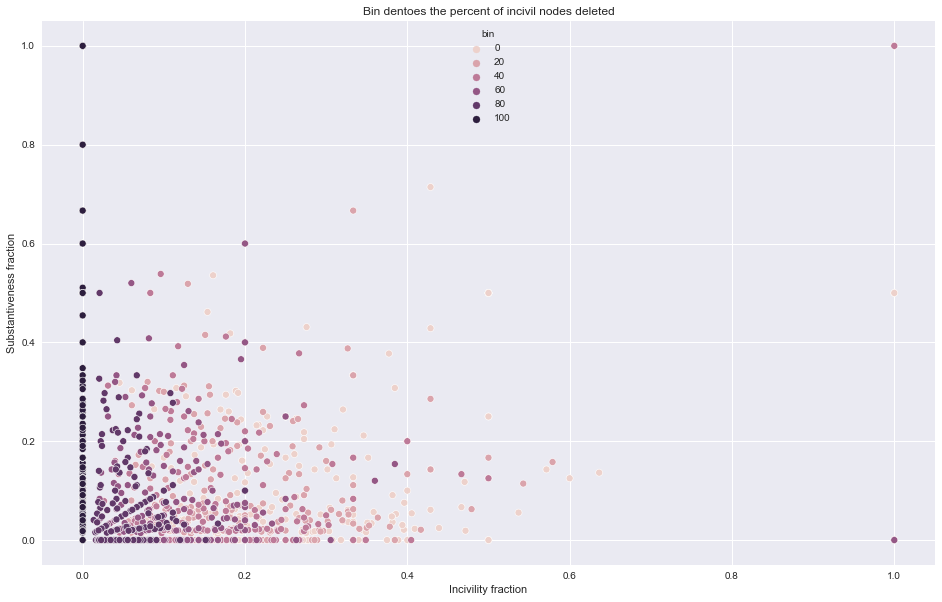

In [46]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)

# sns.scatterplot(x=[0,0,0],y=[0,5,10])
sns.scatterplot(data=df, x="inc", y="sub", hue="bin").set(xlabel="Incivility fraction", ylabel="Substantiveness fraction", title="Bin dentoes the percent of incivil nodes deleted")

plt.savefig("bin_removal_scatter.pdf", bbox_inches='tight')

In [50]:
for i in pearson:
    print(i)

(0.08051862935746225, 0.12413657573378648)
(-0.05081772859604077, 0.3322951115660259)
(-0.043881805124983665, 0.40257011495034367)
(-0.031462939970846475, 0.5484988583967656)
(-0.03404745057948223, 0.5161275198921226)
(-0.017090689299682334, 0.7445230913317504)
(-0.11278051478410199, 0.03146184983922244)
(-0.1353892571008891, 0.009808274089259625)
(-0.16442509868847865, 0.001670347975861835)
(-0.11534300563153752, 0.027996274690542985)
(nan, nan)


In [ ]:
# agressive method of deletion

In [1]:
import networkx as nx

In [2]:
imm_nx = nx.read_gexf("_conversations_relevant_modified_with_attributes.gexf")

In [3]:
subgraphs=list(imm_nx.subgraph(c) for c in nx.connected_components(imm_nx.to_undirected()))

In [10]:
# print(subgraphs[0].is_directed())

True


In [161]:
# mod_sg_list=[]
# coin = [0,1]
# for sg in subgraphs:
#     mod_sg=sg
#     attr_sub = nx.get_node_attributes(sg,"label")
#     attr_inc = nx.get_node_attributes(sg,"incivility")
#     root = [n for n,d in sg.out_degree() if d==0] 
#     first_nodes = list(sg.predecessors((root[0])))
#     for i in first_nodes: # so far implementation is for only the 1st nodes.
#         choice = random.choice(coin)
#         if (choice==1 and attr_inc[i]==1.0 and len(list(sg.predecessors(i)))!=0):
#             children = child(sg,list(sg.predecessors(i)),[])
#             mod_sg = del_nodes(sg,children)
#             sg=mod_sg # changing sg to mod_sg is creating problems
#     mod_sg_list.append(mod_sg)
        

AttributeError: 'Graph' object has no attribute 'predecessors'

In [157]:
# len(mod_sg_list)

366

In [158]:
# mod_sg_list[0].nodes

NodeView(('1255484280916115458', '1255272961331822593', '1255499209236717570', '1255274302750031872'))

In [127]:
# subgraphs[0].nodes

NodeView(('1255484280916115458', '1255272961331822593', '1255499209236717570', '1255274302750031872'))

In [82]:
# def child(sg,preds,children):
#     if len(preds)==0:
#         return children
#     else:
#         for i in preds:
#             temp = (list(sg.predecessors(i)))
#             children.append(temp)
#             return child(sg,temp,children)


In [72]:
# def del_nodes(sg,children):
#     nodes=[]
#     for i in children:
#         nodes.extend(i)
#     x=nx.Graph(sg)
#     x.remove_nodes_from(nodes)
#     return x

In [84]:
# # try 2 to delete sub tree - Amir's method

# paths={}
# all_paths=[]
# coin = [0,1]
# for c,sg in enumerate(subgraphs):
#     attr_sub = nx.get_node_attributes(sg,"label")
#     attr_inc = nx.get_node_attributes(sg,"incivility")
#     root = [n for n,d in sg.out_degree() if d==0] 
#     first_nodes = list(sg.predecessors((root[0])))
#     leaf_nodes = [n for n,d in sg.in_degree() if d==0]
#     try:
#         num_to_del = np.random.randint(0,len(first_nodes),1)
#     except:
#         num_to_del = 0
#     if num_to_del!=0:
#         nodes_to_del = np.random.randint(0,len(first_nodes),num_to_del)
#         # nodes_to_del=[]
#         for n,i in enumerate(first_nodes): 
#             if (n in nodes_to_del  and attr_inc[i]==1.0):
#                 for j in leaf_nodes:
#                     path = []
#                     try:
#                         path = nx.shortest_path(sg,j,i)
#                         # print(path,j,i)
#                     except:
#                         continue
#                     all_paths.append(path)
#         paths[c]=all_paths
#         all_paths=[]
#     else:
#         paths[c] = 0

In [104]:
# # try 2 to delete sub tree - Amir's method - biased coin

# def get_degree_paths(sg,first_nodes,p): 
#     paths={}
#     all_paths=[]
#     for c,sg in enumerate(subgraphs):
#         attr_sub = nx.get_node_attributes(sg,"label")
#         attr_inc = nx.get_node_attributes(sg,"incivility")
#         root = [n for n,d in sg.out_degree() if d==0] 
#         # first_nodes = list(sg.predecessors((root[0])))
#         leaf_nodes = [n for n,d in sg.in_degree() if d==0]
#         nodes_to_del=[]
#         try:
#             num_to_del = np.random.randint(0,len(first_nodes),1)
#         except:
#             num_to_del = 0
#         if num_to_del!=0:
#             for num in range(0,len(first_nodes)):
#                 choice = random.random()
#                 if choice <=p:
#                     nodes_to_del.append(num)
#             # nodes_to_del = np.random.randint(0,len(first_nodes),num_to_del)
#             for n,i in enumerate(first_nodes): 
#                 if (n in nodes_to_del  and attr_inc[i]==1.0):
#                     for j in leaf_nodes:
#                         path = []
#                         try:
#                             path = nx.shortest_path(sg,j,i)
#                             # print(path,j,i)
#                         except:
#                             continue
#                         all_paths.append(path)
#             if len(all_paths)!=0:
#                 paths[c]=all_paths
#                 all_paths=[]
#             else:
#                 paths[c]=0
#         else:
#             paths[c] = 0
#     return paths

In [106]:
# def id_nodes(paths):
#     nodes = {}
#     for i in paths:
#         if paths[i]!=0:
#             nodes[i] = [x for xs in paths[i] for x in xs]
#         else:
#             nodes[i]=0
#     return nodes

In [107]:
# def create_modified_graphs(sugbraphs,nodes):
#     new_graph={}
#     for c,sg in enumerate(subgraphs):
#         to_add_edges = []
#         for edge in sg.edges:
#             if nodes[c]!=0:
#                 if (edge[0] not in nodes[c] and edge[1] not in nodes[c]):
#                     to_add_edges.append(edge)
#                 new_graph[c] = nx.DiGraph(to_add_edges)
#             else:
#                 new_graph[c] = nx.Graph(sg)
#     return new_graph

In [108]:
# def calc_inc_sub_frac(subgraphs,new_graph,bin_no)
#     all_inc=[]
#     all_sub=[]
#     graph_type=[]
#     org_inc_list=[]
#     new_inc_list=[]
#     org_sub_list=[]
#     new_sub_list=[]
#     for c,sg in enumerate(subgraphs):
#         #add the levels thing here
#         inc_org = list(nx.get_node_attributes(sg,"incivility").values())
#         inc_new = list(nx.get_node_attributes(new_graph[c],"incivility").values())
#         inc_org_count = Counter(inc_org)
#         inc_new_count = Counter(inc_new)
#         sub_org = list(nx.get_node_attributes(sg,"label").values())
#         sub_new = list(nx.get_node_attributes(new_graph[c],"label").values())
#         sub_org_count = Counter(sub_org)
#         sub_new_count = Counter(sub_new)
#         inc_org_frac = (inc_org_count[1.0]/len(inc_org)) if len(inc_org)!=0 else None
#         inc_new_frac = (inc_new_count[1.0]/len(inc_new)) if len(inc_new)!=0 else None
#         sub_org_frac = ((sub_org_count["L3"] + sub_org_count["L4"]) / len(sub_org)) if len(sub_org)!=0 else None
#         sub_new_frac = ((sub_new_count["L3"] + sub_new_count["L4"]) / len(sub_new)) if len(sub_new)!=0 else None
#         all_inc.append(inc_org_frac)
#         all_inc.append(inc_new_frac)
#         org_inc_list.append(inc_org_frac)
#         if inc_new_frac!=None:
#             new_inc_list.append(inc_new_frac)
#         all_sub.append(sub_org_frac)
#         all_sub.append(sub_new_frac)
#         org_sub_list.append(sub_org_frac)
#         if inc_new_frac!=None:
#             new_sub_list.append(sub_new_frac)
#         graph_type.append(bin_no)
#         # graph_type.append("new")

In [109]:
stats.pearsonr(new_inc_list, new_sub_list)

(0.08944957062996299, 0.0874797861159737)

In [102]:
stats.pearsonr(org_inc_list, org_sub_list)

(0.08944957062996299, 0.0874797861159737)

In [55]:
df = pd.DataFrame({"inc":all_inc, "sub":all_sub, "type":graph_type})

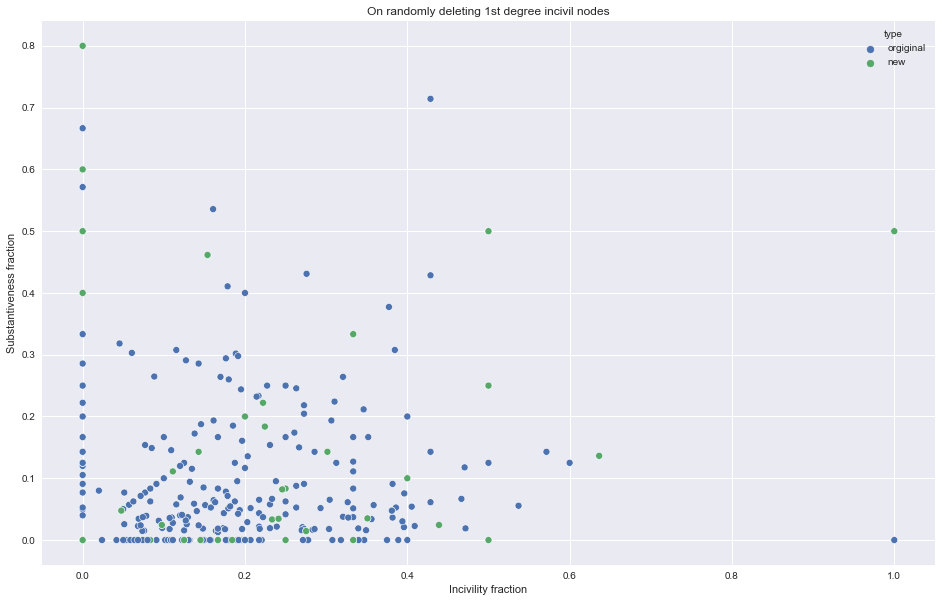

In [58]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)

# sns.scatterplot(x=[0,0,0],y=[0,5,10])
sns.scatterplot(data=df, x="inc", y="sub", hue="type").set(xlabel="Incivility fraction", ylabel="Substantiveness fraction", title="On randomly deleting 1st degree incivil nodes")

plt.savefig("bin_removal_scatter.pdf", bbox_inches='tight')

In [110]:
# def get_level_nodes(sg):
#     # level_dict={}
#     # for c,sg in enumerate(subgraphs):
#     level_nodes={}
#     root = [n for n,d in sg.out_degree() if d==0] 
#     level=0
#     level_nodes[level]=root
#     while (len(root)!=0):
#         level+=1
#         temp=[]
#         for i in root:
#             temp.extend(list(sg.predecessors((i))))
#         if len(temp)!=0:
#             level_nodes[level]=temp
#         root=temp
#     level_dict[c]=level_nodes
#     return level_nodes

In [4]:
# try 2 to delete sub tree - Amir's method - biased coin

def get_degree_paths(sg,first_nodes,p): 
    all_paths=[]
    # for c,sg in enumerate(subgraphs):
    attr_sub = nx.get_node_attributes(sg,"label")
    attr_inc = nx.get_node_attributes(sg,"incivility")
    root = [n for n,d in sg.out_degree() if d==0] 
    # first_nodes = list(sg.predecessors((root[0])))
    leaf_nodes = [n for n,d in sg.in_degree() if d==0]
    nodes_to_del=[]
    for num in range(0,len(first_nodes)):
        choice = random.random()
        if choice <=p:
            nodes_to_del.append(num)
    # nodes_to_del = np.random.randint(0,len(first_nodes),num_to_del)
    for n,i in enumerate(first_nodes): 
        if (n in nodes_to_del  and attr_inc[i]==1.0):
            for j in leaf_nodes:
                path = []
                try:
                    path = nx.shortest_path(sg,j,i)
                    # print(path,j,i)
                except:
                    continue
                all_paths.append(path)
    if len(all_paths)!=0:
        paths=all_paths
        all_paths=[]
    else:
        paths=0
    return paths

In [5]:
def id_nodes(paths):
    # nodes = {}
    # for i in paths:
    if paths!=0:
        nodes = [x for xs in paths for x in xs]
    else:
        nodes=0
    return nodes

In [6]:
def create_modified_graphs(sg,nodes):
    # new_graph={}
    # for c,sg in enumerate(subgraphs):
    to_add_edges = []
    for edge in sg.edges:
        if nodes!=0:
            if (edge[0] not in nodes and edge[1] not in nodes):
                to_add_edges.append(edge)
            new_graph = nx.DiGraph(to_add_edges)
        else:
            new_graph = nx.Graph(sg)
    return new_graph

In [7]:
def get_level_nodes(sg):
    # level_dict={}
    # for c,sg in enumerate(subgraphs):
    level_nodes={}
    root = [n for n,d in sg.out_degree() if d==0] 
    level=0
    level_nodes[level]=root
    while (len(root)!=0):
        level+=1
        temp=[]
        for i in root:
            temp.extend(list(sg.predecessors((i))))
        if len(temp)!=0:
            level_nodes[level]=temp
        root=temp
    # level_dict[c]=level_nodes
    return level_nodes

In [79]:
def calc_inc_sub_frac(subgraphs):
    all_inc=[]
    all_sub=[]
    graph_type=[]
    org_inc_list=[]
    new_inc_list=[]
    org_sub_list=[]
    new_sub_list=[]
    inc_sub_dict={}
    tree_dict={}
    for c,sg in enumerate(subgraphs):
        level_nodes = get_level_nodes(sg)
        level_inc_sub={}
        level_tree_dict={}
        for n,i in enumerate(level_nodes):
            if(n!=0):
                nodes = level_nodes[i]
                paths = get_degree_paths(sg,nodes,0.7)
                node_ids = id_nodes(paths)
                new_graph = create_modified_graphs(sg,node_ids)
        # inc_org = list(nx.get_node_attributes(sg,"incivility").values())
                inc_new = list(nx.get_node_attributes(new_graph,"incivility").values())
        # inc_org_count = Counter(inc_org)
                inc_new_count = Counter(inc_new)
        # sub_org = list(nx.get_node_attributes(sg,"label").values())
                sub_new = list(nx.get_node_attributes(new_graph,"label").values())
        # sub_org_count = Counter(sub_org)
                sub_new_count = Counter(sub_new)
        # inc_org_frac = (inc_org_count[1.0]/len(inc_org)) if len(inc_org)!=0 else None
                inc_new_frac = (inc_new_count[1.0]/len(inc_new)) if len(inc_new)!=0 else None
        # sub_org_frac = ((sub_org_count["L3"] + sub_org_count["L4"]) / len(sub_org)) if len(sub_org)!=0 else None
                sub_new_frac = ((sub_new_count["L3"] + sub_new_count["L4"]) / len(sub_new)) if len(sub_new)!=0 else None
                level_inc_sub[n] = [inc_new_frac,sub_new_frac]
                level_tree_dict[n]=new_graph
        inc_sub_dict[c] = level_inc_sub
        tree_dict[c] = level_tree_dict
    return inc_sub_dict,tree_dict

In [80]:
def binning(subgraphs):
    inc_sub_dict,tree_dict = calc_inc_sub_frac(subgraphs)
    # percent = np.arange(10,110,10)
    percent = np.arange(2,10,2)
    binning_inc={}
    binning_sub={}
    bin_lengths={}
    for i in percent:
        inc_val=[]
        sub_val=[]
        diff_lengths=[]
        for c,sg in enumerate(subgraphs):
            l = int(np.ceil((i/100)*len(inc_sub_dict[c])))
            inc_val.append(inc_sub_dict[c][l][0])
            sub_val.append(inc_sub_dict[c][l][1])
            diff_lengths.append(len(list(sg.nodes))-len(list(tree_dict[c][l].nodes)))
        binning_inc[i]=inc_val
        binning_sub[i]=sub_val
        bin_lengths[i]=diff_lengths
    return binning_inc, binning_sub, bin_lengths

In [81]:
%%time

pearson_list=[]
mean_list=[]
for seed in range(0,100):
    np.random.seed(seed)
    # print(seed)
    pearson=[]
    mean_bin=[]
    binning_inc, binning_sub, bin_lengths = binning(subgraphs)
    for i in binning_inc:
        mean_bin.append(np.mean(bin_lengths[i]))
        inc=[]
        sub=[]
        for n,j in enumerate(binning_inc[i]):
            if j!=None or binning_sub[i][n]!=None:
                inc.append(j)
                sub.append(binning_sub[i][n])
        pearson.append(stats.pearsonr(inc,sub))
    mean_list.append(mean_bin)
    pearson_list.append(pearson)

CPU times: total: 26min 53s
Wall time: 27min 2s


In [82]:
bin_nodes_del = {}

for i in range(0,len(mean_list[0])):
    bin_nodes_del[i] = [item[i] for item in mean_list]

In [83]:
for i in bin_nodes_del:
    print(np.mean(bin_nodes_del[i]),np.std(bin_nodes_del[i]))

4.451338797814207 0.13947957375372416
4.3845355191256825 0.12152827326995737
4.198770491803279 0.0889287601126203
4.150491803278689 0.09030844521227242


In [84]:
bin_pearson = {}

for i in range(0,len(pearson_list[0])):
    bin_pearson[i] = [item[i] for item in pearson_list]

In [85]:
r_mean_list=[]
r_std_list=[]
p_mean_list=[]
p_std_list=[]

for i in bin_pearson:
    r = [item[0] for item in bin_pearson[i]]
    r_mean = np.mean(r)
    r_std = np.std(r)
    r_mean_list.append(r_mean)
    r_std_list.append(r_std)
    p = [item[1] for item in bin_pearson[i]]
    p_mean = np.mean(p)
    p_std = np.std(p)
    p_mean_list.append(p_mean)
    p_std_list.append(p_std)

In [86]:
for i,n in enumerate(p_mean_list):
    print("Bin="+str(i*10)+", r="+str(r_mean_list[i])+", p-value="+str(n))

Bin=0, r=0.203480446990577, p-value=0.04097488045488529
Bin=10, r=0.1850754767229355, p-value=0.061910430761330695
Bin=20, r=0.18449091426800307, p-value=0.060099788115852384
Bin=30, r=0.177308301500123, p-value=0.06916969126424222


In [87]:
for i,n in enumerate(p_std_list):
    print("Bin="+str(i*10)+", r="+str(r_std_list[i])+", p-value="+str(n))

Bin=0, r=0.03944705524080122, p-value=0.0622922578477753
Bin=10, r=0.03979703122054126, p-value=0.07914777327910437
Bin=20, r=0.03972447014123068, p-value=0.07801960583415883
Bin=30, r=0.04013359412284154, p-value=0.09006248933934133
